In [1]:
# The C2QA package is currently not published to PyPI.
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
from quspin.tools.measurements import obs_vs_time  # t_dep measurements
from quspin.tools.Floquet import Floquet_t_vec
from quspin.tools.evolution import evolve  # ODE evolve tool
from quspin.operators import hamiltonian  # operators
from quspin.basis import boson_basis_1d  # Hilbert space boson basis
from quspin.basis import tensor_basis, spinless_fermion_basis_1d  # Hilbert spaces
from quspin.basis import spin_basis_1d  # Hilbert space spin basis

import c2qa
import util
from scipy.sparse.linalg import eigsh

### Build basis and Hamiltonian

In [3]:
Nsites = 2
Nbosons = 2
###### parameters
L_spin = Nsites - 1
L_modes = Nsites  # system size
cutoff = Nbosons + 1  #sites+2
h = 1  # field strength
t = 1

### Build projector onto gauge conserving basis

In [4]:
P_sparse = util.gauge_peserving_basis(Nsites, Nbosons)

In [5]:
# building the two bases to tensor together
basis_spin = spin_basis_1d(L=L_spin)
basis_boson = boson_basis_1d(L=L_modes, sps=cutoff)
# print(basis_boson)
basis = tensor_basis(basis_spin, basis_boson)
# print(basis)

### Build Hamiltonian and calculate ground state

#### Hopping dominates: ground state is (1/2 |2+0> + 1/2 |0+2> + 1/sqrt(2) |1-1>)

In [6]:
Hgaugefixed = util.build_H(-10,0, L_modes, L_spin, P_sparse, basis)
E, psi0 = eigsh(Hgaugefixed, k=1, which='SA')
print(np.angle(psi0[0])-np.angle(psi0[1]),np.angle(psi0[2])-np.angle(psi0[1]),np.angle(psi0[0])-np.angle(psi0[2]))
print(np.abs(psi0[0]),np.abs(psi0[1]),np.abs(psi0[2]))

[-2.22044605e-16] [-2.22044605e-16] [0.]
[0.5] [0.70710678] [0.5]


### define initial state (ground state of X field)

In [6]:
##### create model
field = [[-h,i] for i in range(L_spin)]
# density = [[0.01,i,i] for i in range(L_modes)]
static=[["x|",field]]#,["|nn",density]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H1 = hamiltonian(static,[],basis=basis,**no_checks)

H = hamiltonian(static, [], basis=basis, **no_checks)
H_sparse = H.tocsr()
Hgaugefixed = P_sparse @ H_sparse @ P_sparse.T.conj()
_,psi = eigsh(Hgaugefixed,k=1, which='SA')
# P=P_gaugefixed.full()
# psi=np.dot(P.T.conj(),psi)

In [3]:
# ##### define initial state #####
# #Spin - find index of spin state |01>
# ispin = basis_spin.index("01")
# #Boson - find index of Fock state |20>
# iboson = basis_boson.index("02")
# # Ns is the size of the Hilbert space
# psispin = np.zeros(basis_spin.Ns,dtype=np.float64) # for 2 bosons in 2 modes Ns=3 ("20","11","02")
# psispin[ispin] = 1.0
# psiboson = np.zeros(basis_boson.Ns,dtype=np.float64)
# psiboson[iboson] = 1.0
# psi=np.kron(psispin,psiboson)

defining via product state (not in use)

In [11]:
##### define initial state #####
psispin=(1/np.sqrt(2))*np.array([1,1])
#Boson - find index of Fock state |20>
iboson = basis_boson.index("010")
# Ns is the size of the Hilbert space
psiboson = np.zeros(basis_boson.Ns,dtype=np.float64)
psiboson[iboson] = 1.0
psi=np.kron(psispin,psiboson)

##### Check state we just made (not in use)

In [14]:
field = [[1.0,2]] #second index chooses which spin or mode to check (ie. 0 is the 1st mode, 1 is the second and same for spins)
static=[["|n",field]] #z| checks magnetization of spins, |n checks boson number in modes
no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
H_check = hamiltonian(static,[],basis=basis,**no_checks)
print(np.dot(psi.conj().T,H_check.dot(psi)))

ValueError: values in indx falls outside of system

### Time evolve

get real groundstate

In [7]:
hop=[[-1.0,i,i,i+1] for i in range(L_modes-1)]
# DENSITY AT ZERO - density should be converged for 0.01
# density = [[0.01,i,i] for i in range(L_modes)]
field = [[h,i] for i in range(L_spin)]
# static=[["z|+-",hop],["z|-+",hop],["x|",field]]
static=[["z|+-",hop],["z|-+",hop],["x|",field]]#,["|nn",density]]
###### setting up operators
# set up hamiltonian dictionary and observable (imbalance I)
no_checks = dict(check_pcon=False, check_symm=False, check_herm=False)
H = hamiltonian(static, [], basis=basis, **no_checks)
H_sparse = H.tocsr()
Hgaugefixed = P_sparse @ H_sparse @ P_sparse.T.conj()
_,psi1 = eigsh(Hgaugefixed, k=1, which='SA')
# psi1=np.dot(P.T.conj(),psi1)[:,0]

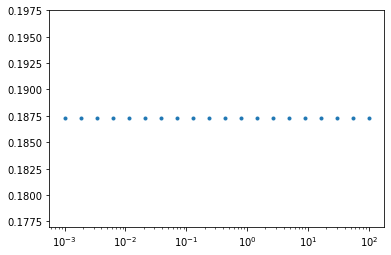

In [8]:
##### create model
def drive(t,t_0):
    return t/t_0

res=[]
t0s=np.logspace(-3,2,20)
for t0 in t0s:
    drive_args=[t0]
    hop=[[-1.0,i,i,i+1] for i in range(L_modes-1)]
    density = [[0.01,i,i] for i in range(L_modes)]
    field = [[h,i] for i in range(L_spin)]
    # static=[["z|+-",hop],["z|-+",hop],["x|",field]]
    # set up hamiltonian dictionary and observable (imbalance I)
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    static=[["x|",field],["|nn",density]]
    dynamic=[]
    Hs = hamiltonian(static,dynamic,basis=basis,**no_checks)
    static = []
    dynamic = [["z|+-",hop,drive,drive_args],["z|-+",hop,drive,drive_args]]
    Hd = hamiltonian(static,dynamic,basis=basis,**no_checks)
    Hs = Hs.tocsr()
    Hd = Hd.tocsr()

    Hsgaugefixed = P_sparse @ Hd @ P_sparse.T.conj()
    Hdgaugefixed = P_sparse @ Hd @ P_sparse.T.conj()

    def adiabatic(time,phi):
        phi_dot = -1j*Hsgaugefixed@phi
        phi_dot += -1j*drive(time,t0)*Hdgaugefixed@phi
        return phi_dot

    # psi_t=H.evolve(psi,0.0,[t0],iterate=False,rtol=1E-9,atol=1E-9)
    psi_t=evolve(psi,0.0,[t0],adiabatic,iterate=False,rtol=1E-9,atol=1E-9)
    # calculate fidelity
    res.append(np.abs(np.dot(psi_t[:,0,0].conj(),psi1))**2)
plt.plot(t0s,res,'.')
plt.xscale('log')

plot occupations (not in use)

In [11]:
##### create model
res=[]
N_timesteps=20
t0s=np.logspace(-3,1,N_timesteps)
for t0 in t0s:
    hop=[[-1.0,i,i,i+1] for i in range(L_modes-1)]
    field = [[-h,i] for i in range(L_spin)]
    no_checks = dict(check_pcon=False,check_symm=False,check_herm=False)
    static=[["x|",field],["z|+-",hop],["z|-+",hop]]
    dynamic=[]
    H = hamiltonian(static,dynamic,basis=basis,**no_checks)
    ###### setting up operators

    H = H.tocsr()

    def adiabatic(time,phi):
        phi_dot = -1j*H@phi
        return phi_dot

    # psi_t=H.evolve(psi,0.0,[t0],iterate=False,rtol=1E-9,atol=1E-9)
    psi_t=evolve(psi1,0.0,[t0],adiabatic,iterate=False,rtol=1E-9,atol=1E-9)

In [18]:
obs_args={"basis":basis,"check_herm":False,"check_symm":False}
n=hamiltonian([["|n", [[1.0,1]] ]],[],dtype=np.float64,**obs_args)
Obs_t = obs_vs_time(psi_t,t,{"n":n})
O_n = Obs_t["n"]
print(O_n)

[1.16016406+0.j]


/tmp/ipykernel_2810/666753308.py:2: UserWarning: Test for particle conservation not implemented for <class 'quspin.basis.tensor.tensor_basis'>, to turn off this warning set check_pcon=False in hamiltonian
  n=hamiltonian([["|n", [[1.0,1]] ]],[],dtype=np.float64,**obs_args)


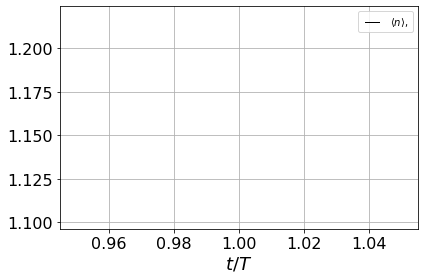

In [13]:
##### plot results #####
import matplotlib.pyplot as plt
import pylab
str_n = "$\\langle n\\rangle,$"
fig = plt.figure()
plt.plot(t,np.real(O_n),"k",linewidth=1,label=str_n)
plt.xlabel("$t/T$",fontsize=18)
# plt.ylim([-1.1,1.4])
plt.legend(loc="upper right",ncol=5,columnspacing=0.6,numpoints=4)
plt.tick_params(labelsize=16)
plt.grid(True)
plt.tight_layout()
#plt.savefig('example3.pdf', bbox_inches='tight')
plt.show()
# plt.close()

In [ ]:
plt.pcolormesh(np.arange(Nsites+1)-Nsites//2-0.5,np.arange(N_timesteps+1)*dt,occupations[0],cmap=matplotlib.cm.Blues,linewidth=0,rasterized=True)
plt.title("Mode occupation: gauge field flipping dominates")
plt.xlabel("Modes")
plt.ylabel("Time")
plt.colorbar()